In [20]:
import argparse
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [21]:
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=64, help="batch size")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--latent_dim", type=int, default=100, help="dimension of the latent space")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of image dimension")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--ngf", type=int, default=64, help="size of feature maps in generator")
parser.add_argument("--ndf", type=int, default=64, help="size of feature maps in discriminator")
parser.add_argument("--multiplier", type=float, default=0.6, help="weighting multiplier, which controls the relative contribution of generated data to the classifier training ")
parser.add_argument("--threshold", type=float, default=0.7, help="confidence threshold, which controls the quality of data to be used for classifier training")
parser.add_argument("--datasize", type=float, default=0.1, help="atasize")

opt, unknown = parser.parse_known_args()

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
from models.models import *
from utility.util import *

NameError: name 'opt' is not defined

In [6]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
criterion = nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()
netC = ResNet18()

generator.to(device)
discriminator.to(device)
netC.to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optC = torch.optim.Adam(netC.parameters(), lr=opt.lr, betas=(0.5, 0.999), weight_decay = 1e-3)

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

In [7]:
transform = transforms.Compose([
        transforms.Resize(32),          # Resize to the same size
        transforms.RandomCrop(32, padding=4),      # Crop to get square area
        transforms.RandomRotation(10),
        transforms.ToTensor(),            
        transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# regular data loaders
batch_size = opt.batch_size
trainset = datasets.SVHN("datasets/SVHN", split='train', download = True, transform=transform)
traindataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.SVHN("datasets/SVHN", split='test', download = True, transform=transform_test)
testloader= torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                           shuffle=False, num_workers=2)

#create subsets
dataSizeConstant = opt.datasize
subTrainSet,_ = torch.utils.data.random_split(trainset, [int(dataSizeConstant*len(trainset)), len(trainset)-int(dataSizeConstant*len(trainset))])

Using downloaded and verified file: datasets/SVHN\train_32x32.mat


100.0%


In [10]:
def validate():
    netC.eval()
    correct = 0
    total = 0
    global gpred_labels, greal_labels
    gpred_labels = torch.empty(0).to(device)
    greal_labels = torch.empty(0).to(device)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = netC(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            gpred_labels = torch.cat((gpred_labels, torch.flatten(predicted)))
            greal_labels = torch.cat((greal_labels, torch.flatten(labels)))
    
    print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))

In [11]:
imgs = []
for data in subTrainSet:
        img, target = data
        imgs.append((img, target))
weights = make_weights_for_balanced_classes(imgs, 10)
weights = torch.DoubleTensor(weights)

subTrainLoader = gain_sample_w(subTrainSet, batch_size= batch_size, weights=weights)

In [12]:
G_losses = []
D_losses = []
C_losses = []
# ----------
#  Training
# ----------
for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(subTrainLoader):

        batch_size = imgs.shape[0]
        validlabel = Variable(FloatTensor(batch_size, ).fill_(1.0), requires_grad=False).to(device)
        fakelabel = Variable(FloatTensor(batch_size, ).fill_(0.0), requires_grad=False).to(device)
        
        real_imgs = Variable(imgs.type(FloatTensor)).to(device)
        labels = Variable(labels.type(LongTensor)).to(device)
        
        #---------------------------------
        # (1) Update D network: 
        #---------------------------------
        # Train with all-real data batch
        discriminator.zero_grad()
        # Forward pass real batch through D
        output = discriminator(real_imgs, labels).view(-1)
        # Calculate loss on all-real batch
        errD_real = adversarial_loss(output, validlabel)
        # Calculate gradients for D in backward pass
        errD_real.backward()

        # Train with all-fake data batch
        # Generate batch of latent vectors and fake labels
        z = torch.randn(batch_size, opt.latent_dim, 1, 1, device = device)
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))
        # Generate fake image batch with G
        fake =  generator(z, labels)
        # Discriminate all fake batch with D
        output = discriminator(fake.detach(), labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = adversarial_loss(output, fakelabel)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward(retain_graph = True)
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizer_D.step()
        
        #---------------------------------
        # (2) Update G network: 
        #---------------------------------
        generator.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake, labels).view(-1)
        # Calculate G's loss based on this output
        errG = adversarial_loss(output, validlabel)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizer_G.step()
        
        #---------------------------------
        #(3) Updata C network:
        #---------------------------------
        # train classifier on real data
        
        fake = fake.detach().clone()
        predictions = netC(real_imgs)
        realClassifierLoss = criterion(predictions, labels)
        realClassifierLoss.backward(retain_graph = True)

        optC.step()
        optC.zero_grad()
        
        # train classifier on the synthesized data selected by the discriminator with a confidence being greater than or equal to β.
        x = output.ge(opt.threshold)
        Drealfake = fake[x]
        Dreallabels = labels[x]
        if Drealfake.shape[0]!=0:
            
            predictionsFake = netC(Drealfake)
            fakeClassifierLoss = criterion(predictionsFake, Dreallabels)*opt.multiplier
            fakeClassifierLoss.backward()

            optC.step()
            optC.zero_grad()
        
        if i % 50 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss: %f]"
                % (epoch, opt.n_epochs, i, len(subTrainLoader), errD.item(), errG.item(), realClassifierLoss.item()))
            
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        C_losses.append(realClassifierLoss.item())
        
        batches_done = epoch * len(subTrainLoader) + i
        
    validate()

[Epoch 0/250] [Batch 0/115] [D loss: 1.526990] [G loss: 1.214832] [C loss: 2.362360]
[Epoch 0/250] [Batch 50/115] [D loss: 0.134796] [G loss: 5.655504] [C loss: 2.260709]
[Epoch 0/250] [Batch 100/115] [D loss: 0.492852] [G loss: 2.476402] [C loss: 2.096727]
Accuracy of the network on the test images: 20.985710 %
[Epoch 1/250] [Batch 0/115] [D loss: 0.338924] [G loss: 3.053576] [C loss: 2.371145]
[Epoch 1/250] [Batch 50/115] [D loss: 0.378779] [G loss: 2.994073] [C loss: 2.287731]
[Epoch 1/250] [Batch 100/115] [D loss: 0.443386] [G loss: 3.718242] [C loss: 2.258455]
Accuracy of the network on the test images: 18.427320 %
[Epoch 2/250] [Batch 0/115] [D loss: 0.627661] [G loss: 4.010869] [C loss: 2.265648]
[Epoch 2/250] [Batch 50/115] [D loss: 0.572809] [G loss: 4.950321] [C loss: 2.069336]
[Epoch 2/250] [Batch 100/115] [D loss: 0.333784] [G loss: 3.684714] [C loss: 2.126163]
Accuracy of the network on the test images: 20.132913 %
[Epoch 3/250] [Batch 0/115] [D loss: 0.909169] [G loss: 4.

[Epoch 26/250] [Batch 0/115] [D loss: 0.108003] [G loss: 4.142010] [C loss: 0.323345]
[Epoch 26/250] [Batch 50/115] [D loss: 0.279279] [G loss: 3.813993] [C loss: 0.207736]
[Epoch 26/250] [Batch 100/115] [D loss: 0.113805] [G loss: 4.275492] [C loss: 0.491404]
Accuracy of the network on the test images: 87.672864 %
[Epoch 27/250] [Batch 0/115] [D loss: 0.255597] [G loss: 2.253244] [C loss: 0.489781]
[Epoch 27/250] [Batch 50/115] [D loss: 1.075025] [G loss: 0.759961] [C loss: 0.339577]
[Epoch 27/250] [Batch 100/115] [D loss: 0.200979] [G loss: 3.002604] [C loss: 0.247470]
Accuracy of the network on the test images: 86.712508 %
[Epoch 28/250] [Batch 0/115] [D loss: 0.129452] [G loss: 3.091948] [C loss: 0.174719]
[Epoch 28/250] [Batch 50/115] [D loss: 0.212303] [G loss: 2.339581] [C loss: 0.392211]
[Epoch 28/250] [Batch 100/115] [D loss: 0.100874] [G loss: 3.852004] [C loss: 0.212778]
Accuracy of the network on the test images: 87.300246 %
[Epoch 29/250] [Batch 0/115] [D loss: 0.116517] [

[Epoch 52/250] [Batch 0/115] [D loss: 0.091812] [G loss: 5.152471] [C loss: 0.353979]
[Epoch 52/250] [Batch 50/115] [D loss: 0.090636] [G loss: 3.912617] [C loss: 0.273193]
[Epoch 52/250] [Batch 100/115] [D loss: 0.065783] [G loss: 4.491174] [C loss: 0.146512]
Accuracy of the network on the test images: 90.308082 %
[Epoch 53/250] [Batch 0/115] [D loss: 0.036478] [G loss: 4.602944] [C loss: 0.171352]
[Epoch 53/250] [Batch 50/115] [D loss: 0.060930] [G loss: 4.952035] [C loss: 0.128773]
[Epoch 53/250] [Batch 100/115] [D loss: 0.054472] [G loss: 4.735101] [C loss: 0.312455]
Accuracy of the network on the test images: 90.269668 %
[Epoch 54/250] [Batch 0/115] [D loss: 0.089436] [G loss: 4.456123] [C loss: 0.114638]
[Epoch 54/250] [Batch 50/115] [D loss: 0.052488] [G loss: 5.308016] [C loss: 0.165417]
[Epoch 54/250] [Batch 100/115] [D loss: 0.072906] [G loss: 4.059120] [C loss: 0.287741]
Accuracy of the network on the test images: 89.539797 %
[Epoch 55/250] [Batch 0/115] [D loss: 0.072083] [

[Epoch 78/250] [Batch 0/115] [D loss: 0.069405] [G loss: 4.698556] [C loss: 0.197725]
[Epoch 78/250] [Batch 50/115] [D loss: 0.088335] [G loss: 4.320068] [C loss: 0.129366]
[Epoch 78/250] [Batch 100/115] [D loss: 0.036403] [G loss: 5.418735] [C loss: 0.355868]
Accuracy of the network on the test images: 91.095575 %
[Epoch 79/250] [Batch 0/115] [D loss: 0.074702] [G loss: 4.157650] [C loss: 0.137672]
[Epoch 79/250] [Batch 50/115] [D loss: 0.046015] [G loss: 4.460482] [C loss: 0.179151]
[Epoch 79/250] [Batch 100/115] [D loss: 0.041076] [G loss: 5.031766] [C loss: 0.148078]
Accuracy of the network on the test images: 90.711432 %
[Epoch 80/250] [Batch 0/115] [D loss: 0.026473] [G loss: 5.852236] [C loss: 0.063582]
[Epoch 80/250] [Batch 50/115] [D loss: 0.033058] [G loss: 5.202687] [C loss: 0.088237]
[Epoch 80/250] [Batch 100/115] [D loss: 0.019404] [G loss: 5.229425] [C loss: 0.185985]
Accuracy of the network on the test images: 91.206976 %
[Epoch 81/250] [Batch 0/115] [D loss: 0.029141] [

Accuracy of the network on the test images: 91.176245 %
[Epoch 104/250] [Batch 0/115] [D loss: 0.026169] [G loss: 4.901322] [C loss: 0.043722]
[Epoch 104/250] [Batch 50/115] [D loss: 0.027418] [G loss: 5.210153] [C loss: 0.101282]
[Epoch 104/250] [Batch 100/115] [D loss: 0.027078] [G loss: 5.408092] [C loss: 0.119809]
Accuracy of the network on the test images: 91.130148 %
[Epoch 105/250] [Batch 0/115] [D loss: 0.053759] [G loss: 5.312560] [C loss: 0.130002]
[Epoch 105/250] [Batch 50/115] [D loss: 0.030421] [G loss: 5.688507] [C loss: 0.061788]
[Epoch 105/250] [Batch 100/115] [D loss: 0.025797] [G loss: 5.583745] [C loss: 0.052385]
Accuracy of the network on the test images: 90.469422 %
[Epoch 106/250] [Batch 0/115] [D loss: 0.018690] [G loss: 5.593784] [C loss: 0.273246]
[Epoch 106/250] [Batch 50/115] [D loss: 0.023312] [G loss: 5.109860] [C loss: 0.056585]
[Epoch 106/250] [Batch 100/115] [D loss: 0.031517] [G loss: 5.885135] [C loss: 0.166655]
Accuracy of the network on the test imag

[Epoch 129/250] [Batch 100/115] [D loss: 0.048171] [G loss: 6.065453] [C loss: 0.045906]
Accuracy of the network on the test images: 85.333436 %
[Epoch 130/250] [Batch 0/115] [D loss: 0.670336] [G loss: 15.123576] [C loss: 0.228582]
[Epoch 130/250] [Batch 50/115] [D loss: 0.951400] [G loss: 2.195431] [C loss: 0.451933]
[Epoch 130/250] [Batch 100/115] [D loss: 0.063247] [G loss: 5.208929] [C loss: 0.122146]
Accuracy of the network on the test images: 91.314536 %
[Epoch 131/250] [Batch 0/115] [D loss: 0.081120] [G loss: 4.458885] [C loss: 0.109485]
[Epoch 131/250] [Batch 50/115] [D loss: 0.040005] [G loss: 6.078143] [C loss: 0.110103]
[Epoch 131/250] [Batch 100/115] [D loss: 0.056175] [G loss: 5.184731] [C loss: 0.085894]
Accuracy of the network on the test images: 91.287646 %
[Epoch 132/250] [Batch 0/115] [D loss: 0.017727] [G loss: 5.891097] [C loss: 0.057259]
[Epoch 132/250] [Batch 50/115] [D loss: 0.013015] [G loss: 5.211082] [C loss: 0.095864]
[Epoch 132/250] [Batch 100/115] [D loss

[Epoch 155/250] [Batch 50/115] [D loss: 0.036722] [G loss: 5.226376] [C loss: 0.097130]
[Epoch 155/250] [Batch 100/115] [D loss: 0.025608] [G loss: 5.496036] [C loss: 0.026577]
Accuracy of the network on the test images: 91.606484 %
[Epoch 156/250] [Batch 0/115] [D loss: 0.356653] [G loss: 2.111546] [C loss: 0.045796]
[Epoch 156/250] [Batch 50/115] [D loss: 0.065115] [G loss: 5.207684] [C loss: 0.091262]
[Epoch 156/250] [Batch 100/115] [D loss: 0.042327] [G loss: 5.902170] [C loss: 0.087699]
Accuracy of the network on the test images: 91.502766 %
[Epoch 157/250] [Batch 0/115] [D loss: 0.017452] [G loss: 5.819753] [C loss: 0.086227]
[Epoch 157/250] [Batch 50/115] [D loss: 0.033963] [G loss: 5.913326] [C loss: 0.060138]
[Epoch 157/250] [Batch 100/115] [D loss: 0.029096] [G loss: 4.641274] [C loss: 0.066226]
Accuracy of the network on the test images: 91.064843 %
[Epoch 158/250] [Batch 0/115] [D loss: 0.037334] [G loss: 5.091528] [C loss: 0.032592]
[Epoch 158/250] [Batch 50/115] [D loss: 

[Epoch 181/250] [Batch 0/115] [D loss: 0.055718] [G loss: 5.424289] [C loss: 0.158167]
[Epoch 181/250] [Batch 50/115] [D loss: 0.041043] [G loss: 6.058473] [C loss: 0.097685]
[Epoch 181/250] [Batch 100/115] [D loss: 0.022212] [G loss: 5.984008] [C loss: 0.014148]
Accuracy of the network on the test images: 73.870621 %
[Epoch 182/250] [Batch 0/115] [D loss: 0.046103] [G loss: 6.429520] [C loss: 0.829789]
[Epoch 182/250] [Batch 50/115] [D loss: 0.022826] [G loss: 6.265428] [C loss: 0.026784]
[Epoch 182/250] [Batch 100/115] [D loss: 0.048432] [G loss: 4.968266] [C loss: 0.060823]
Accuracy of the network on the test images: 91.183927 %
[Epoch 183/250] [Batch 0/115] [D loss: 0.016896] [G loss: 6.824847] [C loss: 0.068789]
[Epoch 183/250] [Batch 50/115] [D loss: 0.021258] [G loss: 5.994387] [C loss: 0.067786]
[Epoch 183/250] [Batch 100/115] [D loss: 0.007061] [G loss: 6.613548] [C loss: 0.018796]
Accuracy of the network on the test images: 92.148125 %
[Epoch 184/250] [Batch 0/115] [D loss: 0

Accuracy of the network on the test images: 86.259219 %
[Epoch 207/250] [Batch 0/115] [D loss: 0.113650] [G loss: 5.939627] [C loss: 0.289727]
[Epoch 207/250] [Batch 50/115] [D loss: 0.018847] [G loss: 6.351705] [C loss: 0.082004]
[Epoch 207/250] [Batch 100/115] [D loss: 0.079816] [G loss: 7.837712] [C loss: 0.060588]
Accuracy of the network on the test images: 84.653503 %
[Epoch 208/250] [Batch 0/115] [D loss: 0.693240] [G loss: 11.063753] [C loss: 0.254141]
[Epoch 208/250] [Batch 50/115] [D loss: 0.040083] [G loss: 5.099975] [C loss: 0.010656]
[Epoch 208/250] [Batch 100/115] [D loss: 0.026908] [G loss: 5.965356] [C loss: 0.086802]
Accuracy of the network on the test images: 91.299170 %
[Epoch 209/250] [Batch 0/115] [D loss: 0.019232] [G loss: 6.584047] [C loss: 0.035775]
[Epoch 209/250] [Batch 50/115] [D loss: 0.026402] [G loss: 5.797173] [C loss: 0.021553]
[Epoch 209/250] [Batch 100/115] [D loss: 0.011028] [G loss: 6.734595] [C loss: 0.030209]
Accuracy of the network on the test ima

[Epoch 232/250] [Batch 100/115] [D loss: 0.045521] [G loss: 5.469090] [C loss: 0.142060]
Accuracy of the network on the test images: 91.491242 %
[Epoch 233/250] [Batch 0/115] [D loss: 0.071399] [G loss: 5.674640] [C loss: 0.020041]
[Epoch 233/250] [Batch 50/115] [D loss: 0.045269] [G loss: 5.215399] [C loss: 0.083417]
[Epoch 233/250] [Batch 100/115] [D loss: 0.011050] [G loss: 7.238106] [C loss: 0.063964]
Accuracy of the network on the test images: 90.596189 %
[Epoch 234/250] [Batch 0/115] [D loss: 0.014251] [G loss: 6.306259] [C loss: 0.025677]
[Epoch 234/250] [Batch 50/115] [D loss: 0.018235] [G loss: 5.932335] [C loss: 0.069192]
[Epoch 234/250] [Batch 100/115] [D loss: 0.009481] [G loss: 6.283622] [C loss: 0.075587]
Accuracy of the network on the test images: 92.198064 %
[Epoch 235/250] [Batch 0/115] [D loss: 0.012798] [G loss: 6.232557] [C loss: 0.105095]
[Epoch 235/250] [Batch 50/115] [D loss: 0.021424] [G loss: 6.287167] [C loss: 0.032851]
[Epoch 235/250] [Batch 100/115] [D loss:

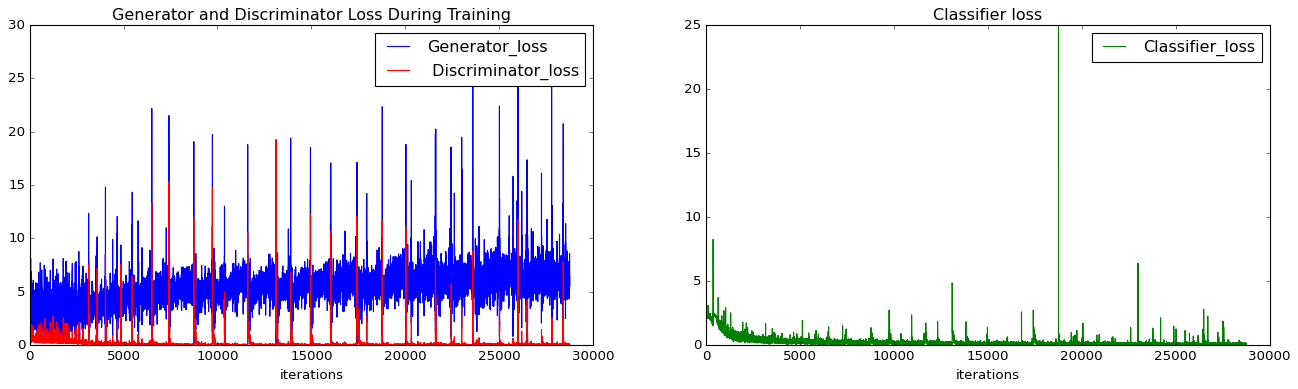

In [16]:
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)

plt.title("Generator and Discriminator Loss During Training")
line1 =plt.plot(G_losses,'b-')
line2 =plt.plot(D_losses,'r-')
plt.legend(labels=['Generator_loss', ' Discriminator_loss'])
plt.xlabel("iterations")

plt.subplot(1, 2, 2)
line3 =plt.plot(C_losses,'g-')
plt.title('Classifier loss')
plt.legend(labels=['Classifier_loss'])
plt.xlabel("iterations")

plt.savefig('Conditional_classifier_GAN.png',dpi=400,bbox_inches='tight')
plt.show()

In [17]:
torch.save(generator, f'generator_{opt.datasize}.pth') 
torch.save(discriminator, f'discriminator_{opt.datasize}.pth')
torch.save(netC, f'netC_{opt.datasize}.pth')